In [5]:
%matplotlib inline

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

In [6]:
df = pd.read_stata('../../../HCMST 2017 fresh sample for public sharing draft v1.1.dta')

In [7]:
chosen_cols = [
    'time_from_met_to_rel',  # numeryczna - czas (w latach), który upłynął od poznania do wejścia w związek
    'time_from_rel_to_cohab', # numeryczna - czas (w latach), który upłynął od wejścia w związek do zamieszkania razem
    'Q25',  # jakościowa - czy uczęszczałeś z partnerem do tej samej szkoły średniej
    'Q12', # jakościowa - jak partner opisuje swoje poglądy polityczne
    'S1',  # output
]
df[chosen_cols].head()

,time_from_met_to_rel,time_from_rel_to_cohab,Q25,Q12,S1
0,0.000000,NaN,NaN,NaN,"No, I am not Married"
1,12.250000,0.500000,Different High School,Leans Republican,"Yes, I am Married"
2,0.416748,0.083252,Different High School,Leans Democrat,"Yes, I am Married"
3,1.083252,NaN,NaN,NaN,"No, I am not Married"
4,0.083252,0.833374,Different High School,Strong Democrat,"Yes, I am Married"


In [8]:
# kilka parametrów danych
print(df[chosen_cols].count())  # liczba niepustych wartości w każdej kolumnie 
print('=' * 30)
print('before drop:', len(df[chosen_cols]))
print('after drop:', len(df[chosen_cols].dropna()))  # liczba wierszy przed i po usunięciu niekompletnych wierszy

cleaner_df = df[chosen_cols].dropna()
cleaner_df['S1'] = cleaner_df['S1'].apply(lambda x: 1 if x == 'Yes, I am Married' else 0)
cleaner_df['S1'] = cleaner_df['S1'].astype('float')  # przekształcenie kolumny wynikowej do postaci 0/1
final_df = cleaner_df
final_df.head()

time_from_met_to_rel      3263
time_from_rel_to_cohab    2578
Q25                       2856
Q12                       2856
S1                        3510
dtype: int64
before drop: 3510
after drop: 2354


,time_from_met_to_rel,time_from_rel_to_cohab,Q25,Q12,S1
1,12.250000,0.500000,Different High School,Leans Republican,1.0
2,0.416748,0.083252,Different High School,Leans Democrat,1.0
4,0.083252,0.833374,Different High School,Strong Democrat,1.0
5,0.500000,0.000000,Different High School,Undecided/Independent/Other,1.0
6,0.250000,2.583374,Different High School,Leans Republican,1.0


In [9]:
X = final_df.loc[:, final_df.columns != 'S1']
y = final_df.loc[:, 'S1']


In [10]:
clf = RandomForestClassifier(**{'max_depth': 7, 'max_features': 3, 'min_samples_split': 2, 'n_estimators': 22},
                             n_jobs=-1)
X_train = pd.get_dummies(X).sort_index(axis=1)
y_train = y
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features=3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=22, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [11]:
# dataframe wyłącznie na potrzebu funkcji get_dummies używanej po ustaleniu parametrów (jeśli ustalimy w całym 
# datasecie wartość kolumn jakościowych - Q12 i Q25 - na tę samą wartość to wywołaniu get_dummies ta kolumna zmieni się
# w pojedynczą kolumną numeryczną, czyli zmieni się wymiarowość i model nie przyjmie takiego przypadku - potrzebujemy 
# zatem "fałszywych" wiersz, w których przechowamy pozostałe wartości)
# użycie wygląda następująco: ustalamy w datasecie kolumnę jakościową na wybraną wartość -> doklejamy do 
# zmodyfikowanego datasetu get_dummies balancer -> wywołujemy get_dummies -> sortujemy kolumny (by były w tej samej
# kolejności) co w zbiorze uczącym -> usuwamy wiersze pochodzace od get_dummies_balancer, by nie wpływały na wyniki
get_dummies_balancer = pd.DataFrame(columns=chosen_cols[:-1],
                                    data=[[0, 0, 'Refused', 'Refused'],
                                          [0, 0, 'Same High School', 'Strong Republican'],
                                          [0, 0, 'Different High School', 'Not Strong Republican'],
                                          [0, 0, 'Refused', 'Leans Republican'],
                                          [0, 0, 'Refused', 'Undecided/Independent/Other'],
                                          [0, 0, 'Refused', 'Leans Democrat'],
                                          [0, 0, 'Refused', 'Not Strong Democrat'],
                                          [0, 0, 'Refused', 'Strong Democrat']])


In [12]:
from itertools import permutations

example_case = X.iloc[352]  # wybranie przykładu
print(example_case)
preds = clf.predict_proba(X_train)
base_mean_pred = preds[:, 1].mean()
print(f"No fixed variables - mean prediction = {base_mean_pred}")
for perm in permutations(chosen_cols[:-1]):  # iteracja po wszystkich permtuacjach kolumn
  X_depen = X.copy()
  print('=' * 40)
  print(f"Current permutation {perm}")
  for col in perm:  # iteracja zgodna kolejnością w permutacji
    X_depen.loc[:, col] = example_case[col] # ustalanie wybranego parametru
    X_depen_to_pred = pd.get_dummies(pd.concat([X_depen, get_dummies_balancer], axis=0)).sort_index(axis=1).iloc[:-len(get_dummies_balancer)]
    # przekształcenie opisane powyżej
    preds = clf.predict_proba(X_depen_to_pred)
    mean_pred = preds[:, 1].mean()
    print(f"After fixing {col} at {example_case[col]} mean prediction = {mean_pred}")


time_from_met_to_rel                    7.5
time_from_rel_to_cohab                    1
Q25                        Same High School
Q12                       Strong Republican
Name: 529, dtype: object
No fixed variables - mean prediction = 0.8267064713754909
Current permutation ('time_from_met_to_rel', 'time_from_rel_to_cohab', 'Q25', 'Q12')
After fixing time_from_met_to_rel at 7.5 mean prediction = 0.8383080373337495
After fixing time_from_rel_to_cohab at 1.0 mean prediction = 0.8597128774810916
After fixing Q25 at Same High School mean prediction = 0.9248886782698447
After fixing Q12 at Strong Republican mean prediction = 0.9351397997468702
Current permutation ('time_from_met_to_rel', 'time_from_rel_to_cohab', 'Q12', 'Q25')
After fixing time_from_met_to_rel at 7.5 mean prediction = 0.8383080373337495
After fixing time_from_rel_to_cohab at 1.0 mean prediction = 0.8597128774810914
After fixing Q12 at Strong Republican mean prediction = 0.9266398180847533
After fixing Q25 at Same High S

After fixing time_from_rel_to_cohab at 1.0 mean prediction = 0.9266398180847533
After fixing Q25 at Same High School mean prediction = 0.9351397997468702
Current permutation ('Q12', 'time_from_met_to_rel', 'Q25', 'time_from_rel_to_cohab')
After fixing Q12 at Strong Republican mean prediction = 0.9156614514354712
After fixing time_from_met_to_rel at 7.5 mean prediction = 0.9143942560723408
After fixing Q25 at Same High School mean prediction = 0.9285019002311414
After fixing time_from_rel_to_cohab at 1.0 mean prediction = 0.9351397997468702
Current permutation ('Q12', 'time_from_rel_to_cohab', 'time_from_met_to_rel', 'Q25')
After fixing Q12 at Strong Republican mean prediction = 0.9156614514354712
After fixing time_from_rel_to_cohab at 1.0 mean prediction = 0.9198216455965849
After fixing time_from_met_to_rel at 7.5 mean prediction = 0.9266398180847533
After fixing Q25 at Same High School mean prediction = 0.9351397997468702
Current permutation ('Q12', 'time_from_rel_to_cohab', 'Q25', '

In [9]:
# Wnioski: widać, że zmienne Q25 o wartości 'Same High School' i 'time_from_rel_to_cohab' o wysokiej wartości 
# (7.5 to znacznie powyżej średniej) są skorelowane - ustawienie pojedynczego z tych parametrów nieznacznie zmienia
# średnią odpowiedź, ale ich wspólne pojawienie się zdecydowanie zwiększa średnią odpowiedź - przykłady poniżej:

# ========================================
# Current permutation ('Q25', 'time_from_met_to_rel', 'time_from_rel_to_cohab', 'Q12')
# After fixing Q25 at Same High School mean prediction = 0.8448116287809999
# After fixing time_from_met_to_rel at 7.5 mean prediction = 0.8906490673966143
# After fixing time_from_rel_to_cohab at 1.0 mean prediction = 0.9248886782698447
# After fixing Q12 at Strong Republican mean prediction = 0.9351397997468702

# ========================================
# Current permutation ('time_from_met_to_rel', 'Q25', 'Q12', 'time_from_rel_to_cohab')
# After fixing time_from_met_to_rel at 7.5 mean prediction = 0.8383080373337495
# After fixing Q25 at Same High School mean prediction = 0.8906490673966143
# After fixing Q12 at Strong Republican mean prediction = 0.9285019002311412
# After fixing time_from_rel_to_cohab at 1.0 mean prediction = 0.9351397997468702

# Widzimy również, że parametr Q12 o wartości 'Strong Republican' ma bardzo duży wpływ na zwiększenie finalnego 
# wyniku, niezależnie od pozostałych parametrów

In [13]:
import matplotlib.pyplot as plt

def plot_waterfall(original_data, X, col_order, model, example_case, balancer):
    preds = model.predict_proba(original_data)
    base_mean_pred = preds[:, 1].mean()

    X_depen = X.copy()
    mean_preds = [base_mean_pred]
    labels = ['base']

    for col in col_order:
        X_depen.loc[:, col] = example_case[col]
        X_depen_to_pred = pd.get_dummies(pd.concat([X_depen, balancer], axis=0)).sort_index(axis=1).iloc[:-len(balancer)]

        preds = model.predict_proba(X_depen_to_pred)
        mean_pred = preds[:, 1].mean()
        mean_preds.append(mean_pred)
        labels.append(f"{col}={example_case[col]}")

    ind = range(len(mean_preds))
    lefts = [min(x, y) for x, y in zip(mean_preds, [0] + mean_preds[:-1])]
    deltas = [base_mean_pred] + [x - y for x, y in zip(mean_preds[1:], mean_preds[:-1])]
    p1 = plt.barh(ind, deltas, left=lefts, height=1.0)
    plt.yticks(range(len(labels)), labels)
    plt.show()

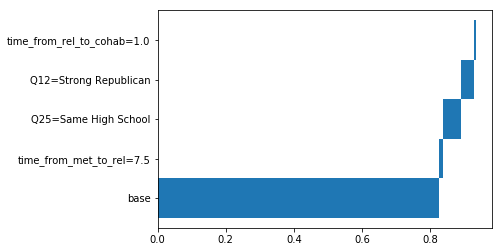

In [16]:
plot_waterfall(original_data=X_train, X=X, col_order=('time_from_met_to_rel', 'Q25', 'Q12', 'time_from_rel_to_cohab'),
              model=clf, example_case=example_case, balancer=get_dummies_balancer)

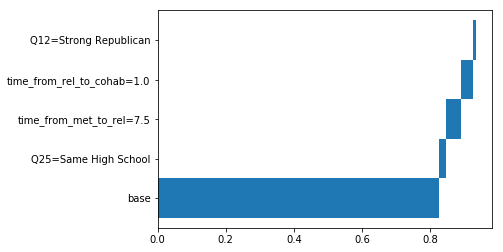

In [17]:
plot_waterfall(original_data=X_train, X=X, col_order=('Q25', 'time_from_met_to_rel', 'time_from_rel_to_cohab', 'Q12'),
              model=clf, example_case=example_case, balancer=get_dummies_balancer)